# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine **which demographic groups respond best to which offer type**. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

# Data Exploration

In [2]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


We see that portfolio has only 10 rows and no missing values.

In [3]:
portfolio['offer_type'].value_counts()

discount         4
bogo             4
informational    2
Name: offer_type, dtype: int64

In [4]:
portfolio.groupby('offer_type').id.count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [5]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [6]:
profile.shape

(17000, 5)

The profile dataset has 17k rows. However, looking at the first rows, we see a lot of NaN values, as well as values that don't make sense(age 118) that we need to clean.

In [7]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
profile[profile.age == 118].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

As it seems, the number 118 is the value for NaN in the age column, and the same rows have missing values in the gender and income columns too, so we will drop them.

In [9]:
profile[profile.age==118].head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN


In [10]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [11]:
transcript.shape

(306534, 4)

In [12]:
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [13]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [14]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

All columns in transcript seem ok except the values one that is a dictionary that we should break down a bit

# Data preprocessing

### Clean profile dataset

In [15]:
def one_hot_encoding(df, column_list):
    
    for column in column_list:
        column_dummies = pd.get_dummies(df[column])
        df = df.drop(column, axis = 1)
        df = df.join(column_dummies)
    return df

In [16]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [17]:
# Drop raws with age 118, which correspond to rows with null values in gender and income too
profile = profile[profile.age < 118].reset_index(drop=True)

# Replace dates of on profile df with datetime values
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')
profile = profile.rename(columns={"id": "person_id"})
profile.head()

,age,became_member_on,gender,person_id,income
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


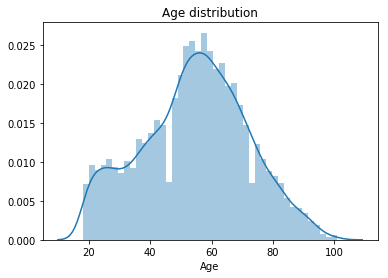

In [18]:
ax = sns.distplot(profile['age'])
ax.set(xlabel='Age')
ax.set_title('Age distribution')
# plt.savefig('plots/age.png', bbox_inches='tight')
plt.show()


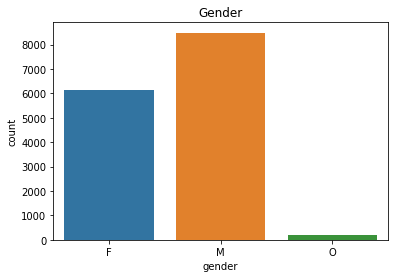

In [19]:
plt.title('Gender')
sns.countplot(x='gender', data=profile)

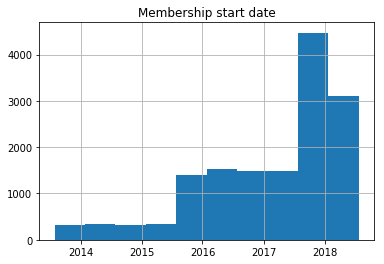

In [20]:
plt.title('Membership start date')
profile['became_member_on'].hist()

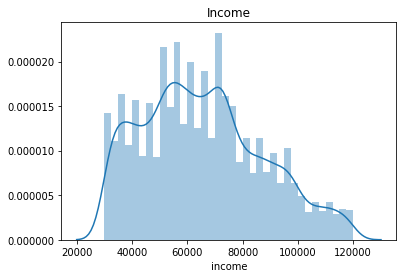

In [21]:
plt.title('Income')
sns.distplot(profile['income'])

In [22]:
# Convert became_member_on to membership length in days

profile['member_days'] =  datetime.today()
profile['member_days'] = (profile['member_days'] - profile['became_member_on'])
profile['member_days'] = profile['member_days'].dt.days
profile_clean = profile.drop("became_member_on", axis=1)
profile_clean.head()

,age,gender,person_id,income,member_days
0,55,F,0610b486422d4921ae7d2bf64640c50b,112000.0,1065
1,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,1132
2,68,M,e2127556f4f64592b11af22de27a7932,70000.0,780
3,65,M,389bc3fa690240e798340f5a15918d5c,53000.0,856
4,58,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,946


In [23]:


profile_clean = one_hot_encoding(profile_clean, ['gender'])

### Clean transcript dataframe

In [24]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [25]:

transcript_clean = one_hot_encoding(transcript, ['event'])
transcript_clean.head()

,person,time,value,offer completed,offer received,offer viewed,transaction
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0
2,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0


In [26]:
# Find keys of value columns
def find_keys(df, column_name):

    keys = []
    for i in range(df.shape[0]):
        for key, value in df[column_name][i].items():
            if key not in keys:
                keys.append(key)
    return keys
    
      
value_keys = find_keys(transcript_clean, 'value')
value_keys    
transcript_clean['value'][1]

{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}

In [27]:
def clean_dict(df, column_name):

    for i in range(df.shape[0]):
        for key, value in df[column_name][i].items():
            if key == 'offer id':
                # dict[new_key] = dict.pop(old_key)
                (df[column_name][i])['offer_id'] = (df[column_name][i]).pop(key)
    return df


transcript_clean =  clean_dict(transcript_clean, 'value')
value_keys = find_keys(transcript_clean, 'value')
value_keys  

['offer_id', 'amount', 'reward']

In [28]:
# Transform each key of value column into column and add it to the dataframe

transcript_clean = pd.concat([transcript_clean, transcript_clean['value'].apply(pd.Series)], axis=1)
transcript_clean.head()

,person,time,value,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,0,{'offer_id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,0,{'offer_id': '2906b810c7d4411798c6938adc9daaa5'},0,1,0,0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,0,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


In [29]:
# Check if reward was set correclty (for columns with positve reward, there was a reward key in the value column)

transcript_clean[transcript_clean.reward > 0]['value'].values

array([{'offer_id': '2906b810c7d4411798c6938adc9daaa5', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9', 'reward': 5}, ...,
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2},
       {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4', 'reward': 2}], dtype=object)

In [30]:
transcript_clean = transcript_clean.drop('value', axis=1)
transcript_clean['reward'].fillna(0, inplace=True)
transcript_clean['amount'].fillna(0, inplace=True)
transcript_clean = transcript_clean.rename(columns={"person": "person_id"})
transcript_clean.head()

,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,0,0,1,0,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0.0,0.0
2,e2127556f4f64592b11af22de27a7932,0,0,1,0,0,2906b810c7d4411798c6938adc9daaa5,0.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,0,0,1,0,0,fafdcd668e3743c1bb461111dcafc2a4,0.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,0,0,1,0,0,4d5c57ea9a6940dd891ad53e9dbe8da0,0.0,0.0


In [31]:
transcript_clean['offer_id'].nunique()

10

### Clean portfolio

In [32]:
# Convert channels to categorical and then get dummies

channels = portfolio['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})

portfolio_clean=pd.concat([portfolio[:], channels[:]], axis=1)
portfolio_clean['web'] = np.where(portfolio_clean['web']=='web',1,0)
portfolio_clean['email'] = np.where(portfolio_clean['email']=='email',1,0)
portfolio_clean['mobile'] = np.where(portfolio_clean['mobile']=='mobile',1,0)
portfolio_clean['social'] = np.where(portfolio_clean['social']=='social',1,0)

portfolio_clean=portfolio_clean.drop('channels',axis=1)

#portfolio_clean #bug in 1st row


portfolio_clean.rename(columns={'id':'offer_id'}, inplace=True)
portfolio_clean

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,0,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0
5,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1
6,10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1
7,0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,0,0,0
8,5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1
9,10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0


In [33]:
portfolio_clean['offer_id'].nunique()

10

In [34]:
# Merge on offer_id
transcript_portfolio = pd.merge(transcript_clean, portfolio_clean, on='offer_id')
transcript_portfolio.head()

,person_id,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,reward_x,difficulty,duration,offer_type,reward_y,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5,7,bogo,5,1,1,1,0
1,ebe7ef46ea6f4963a7dd49f501b26779,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5,7,bogo,5,1,1,1,0
2,f082d80f0aac47a99173ba8ef8fc1909,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5,7,bogo,5,1,1,1,0
3,c0d210398dee4a0895b24444a5fcd1d2,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5,7,bogo,5,1,1,1,0
4,57dd18ec5ddc46828afb81ec5977bef2,0,0,1,0,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0.0,0.0,5,7,bogo,5,1,1,1,0


In [35]:
df = pd.merge(profile, transcript_portfolio, on='person_id')



In [36]:
df= df.drop(['reward_x','reward_y'], axis=1)


In [37]:
df=df.sort_values(['person_id','time'])
df.head()

,age,became_member_on,gender,person_id,income,member_days,time,offer completed,offer received,offer viewed,transaction,offer_id,amount,difficulty,duration,offer_type,web,email,mobile,social
32832,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1150,168,0,1,0,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0,3,informational,0,0,0,0
32833,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1150,192,0,0,1,0,5a8bc65990b245e5a138643cd4eb9837,0.0,0,3,informational,0,0,0,0
32830,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1150,336,0,1,0,0,3f207df678b143eea3cee63160fa8bed,0.0,0,4,informational,1,1,1,0
32831,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1150,372,0,0,1,0,3f207df678b143eea3cee63160fa8bed,0.0,0,4,informational,1,1,1,0
32827,33,2017-04-21,M,0009655768c64bdeb2e877511632db8f,72000.0,1150,408,0,1,0,0,f19421c1d4aa40978ebb69ca19b0e20d,0.0,5,5,bogo,1,1,1,1


In [38]:
# Split by offer

# bogo = df[df['offer_type']=='bogo'].copy()
# discount = df[df['offer_type']=='discount'].copy()
# informational = df[df['offer_type']=='informational'].copy()

In [39]:
# Find offers responded

# Get offers that were received and viewed by the customer
offers_viewed = pd.merge(df.loc[df['offer received'] == 1, ['person_id', 'offer_id', 'time','duration']],
                         df.loc[df['offer viewed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 on=['person_id', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# same but keep all columns
# offers_viewed = pd.merge(df.loc[df['offer received'] == 1],
#                          df.loc[df['offer viewed'] == 1],
#                  on=['person_id', 'offer_id'], how='left', suffixes=['_received', '_viewed'])

# Get offers that were viewed and completed by the customer
offers_completed = pd.merge(df.loc[df['offer viewed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 df.loc[df['offer completed'] == 1, ['person_id', 'offer_id', 'time','duration']],
                 on=['person_id', 'offer_id'], how='left', suffixes=['_viewed', '_completed'])
# offers_completed = pd.merge(df.loc[df['offer viewed'] == 1],
#                  df.loc[df['offer completed'] == 1],
#                  on=['person_id', 'offer_id'], how='left', suffixes=['_viewed', '_completed'])

offers_viewed.head()

# Get information of all completed offers in order to check if they were within the duration of the offer
offers = pd.merge(offers_completed,
                 offers_viewed.loc[offers_viewed['time_viewed'] > 0, ['person_id', 'offer_id', 'time_received']],
                 on=['person_id', 'offer_id'], how='left')
offers.head()




,person_id,offer_id,time_viewed,duration_viewed,time_completed,duration_completed,time_received
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,3,NaN,NaN,168.0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,4,NaN,NaN,336.0
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,5,414.0,5.0,408.0
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,540,10,528.0,10.0,504.0
4,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,6,4,NaN,NaN,0.0


In [40]:
# For all offers viewed but not necessarily completed, mark them as zero
# offers['offer_responded'] = 0

# Convert time(hours) to days
offers['day_received'] = offers['time_received']/24
offers['day_viewed'] = offers['time_viewed']/24
offers['day_completed'] = offers['time_completed']/24

offers=offers.drop(['time_viewed','time_completed','time_received'], axis=1)
offers.rename(columns={'duration_viewed': 'duration'}, inplace=True)


# We want to keep customers who saw the offer before they completed it
condition1 = offers['day_viewed'] <  offers['day_completed'] 
# .. and they completed it within the duration of the offer
condition2 = offers['day_completed'] <= offers['day_received'] + offers['duration']

offers_responded = offers.loc[condition1 & condition2]

# offers_responded = offers_responded.assign(offer_responded=1) 

# Keep also those who bought anyway
condition3 = offers['day_viewed'] > offers['day_completed']
offers_completed_anyway  = offers.loc[condition3]


# Keep those who not responded = viewed but not completed
condition4 = ( (offers['day_viewed'] > 0) & (offers['day_completed'].isna()))
offers_not_responded = offers.loc[condition4]


# Clean columns
offers_responded = offers_responded.drop(['duration_completed'], axis=1)
offers_not_responded = offers_not_responded.drop(['duration_completed'], axis=1)
offers_completed_anyway = offers_completed_anyway.drop(['duration_completed'], axis=1)
offers_responded.head()


,person_id,offer_id,duration,day_received,day_viewed,day_completed
5,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7.0,7.75,10.50
7,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,17.0,18.00,24.00
8,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,21.0,21.50,24.00
9,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10,0.0,0.50,2.25
10,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10,14.0,0.50,2.25


In [41]:
offers_not_responded.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3,7.0,8.00,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4,14.0,15.50,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,4,0.0,0.25,NaN
6,0011e0d4e6b944f998e987f904e8c1e5,5a8bc65990b245e5a138643cd4eb9837,3,14.0,14.75,NaN
14,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,3,21.0,27.50,NaN


In [42]:
offers_completed_anyway.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5,17.0,19.0,17.25
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10,21.0,22.5,22.00
29,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,10,7.0,17.5,16.00
30,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,10,7.0,17.5,16.00
31,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,10,17.0,17.5,16.00


In [43]:
offers = offers.drop(['duration_completed'], axis=1)
offers.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed
0,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,3,7.0,8.00,NaN
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,4,14.0,15.50,NaN
2,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5,17.0,19.00,17.25
3,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,10,21.0,22.50,22.00
4,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,4,0.0,0.25,NaN


In [44]:
offers_responded.shape

(49906, 6)

In [45]:

offers_all = pd.concat([offers_responded, offers_not_responded], keys=['person_id', 'offer_id'])
offers_all.tail()

offers_all['offer_respond'] = offers_all['day_completed']
offers_all['offer_respond'] = offers_all['offer_respond'].fillna(0)
offers_all.loc[offers_all['offer_respond'] > 0, 'offer_respond'] = 1

offers_all.head()

person_id  \
person_id 5   0011e0d4e6b944f998e987f904e8c1e5   
          7   0011e0d4e6b944f998e987f904e8c1e5   
          8   0011e0d4e6b944f998e987f904e8c1e5   
          9   0020c2b971eb4e9188eac86d93036a77   
          10  0020c2b971eb4e9188eac86d93036a77   

                                      offer_id  duration  day_received  \
person_id 5   2298d6c36e964ae4a3e7e9706d1fb8c2         7           7.0   
          7   0b1e1539f2cc45b7b9fa7c272da2e1d7        10          17.0   
          8   9b98b8c7a33c4b65b9aebfe6a799e6d9         7          21.0   
          9   fafdcd668e3743c1bb461111dcafc2a4        10           0.0   
          10  fafdcd668e3743c1bb461111dcafc2a4        10          14.0   

              day_viewed  day_completed  offer_respond  
person_id 5         7.75          10.50            1.0  
          7        18.00          24.00            1.0  
          8        21.50          24.00            1.0  
          9         0.50           2.25            1.0  
          10        0.50           2.25            1.0

In [46]:
offers_all.tail()

person_id  \
offer_id 144928  fff7576017104bcc8677a8d63322b5e1   
         144929  fff7576017104bcc8677a8d63322b5e1   
         144938  fff8957ea8b240a6b5e634b6ee8eafcf   
         144939  fff8957ea8b240a6b5e634b6ee8eafcf   
         144948  fffad4f4828548d1b5583907f2e9906b   

                                         offer_id  duration  day_received  \
offer_id 144928  4d5c57ea9a6940dd891ad53e9dbe8da0         5           7.0   
         144929  ae264e3637204a6fb9bb56bc8210ddfd         7          17.0   
         144938  fafdcd668e3743c1bb461111dcafc2a4        10          17.0   
         144939  4d5c57ea9a6940dd891ad53e9dbe8da0         5          24.0   
         144948  5a8bc65990b245e5a138643cd4eb9837         3           7.0   

                 day_viewed  day_completed  offer_respond  
offer_id 144928        7.50            NaN            0.0  
         144929       17.25            NaN            0.0  
         144938       18.00            NaN            0.0  
         144939       27.50            NaN            0.0  
         144948        7.00            NaN            0.0

In [47]:
offers_all['offer_respond'].value_counts()

1.0    49906
0.0    39783
Name: offer_respond, dtype: int64

In [58]:
# Merge back with df to get the rest of the information
df = pd.merge(offers_all, profile_clean, on='person_id', how="left")
df.head()
# df['offer_respond'].value_counts()




,person_id,offer_id,duration,day_received,day_viewed,day_completed,offer_respond,age,income,member_days,F,M,O
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7.0,7.75,10.50,1.0,40,57000.0,887,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,17.0,18.00,24.00,1.0,40,57000.0,887,0,0,1
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,21.0,21.50,24.00,1.0,40,57000.0,887,0,0,1
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10,0.0,0.50,2.25,1.0,59,90000.0,1563,1,0,0
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10,14.0,0.50,2.25,1.0,59,90000.0,1563,1,0,0


In [59]:
portfolio_clean.head()

,difficulty,duration,offer_id,offer_type,reward,web,email,mobile,social
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,0,0,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0


In [60]:
# portfolio = df[df['offer_type']=='bogo'].copy()

df = pd.merge(df, portfolio_clean, on='offer_id', how="left")
df = df.drop("duration_y",axis=1)
df.rename(columns={'duration_x': 'duration'}, inplace=True)

df.head()

,person_id,offer_id,duration,day_received,day_viewed,day_completed,offer_respond,age,income,member_days,F,M,O,difficulty,offer_type,reward,web,email,mobile,social
0,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,7,7.0,7.75,10.50,1.0,40,57000.0,887,0,0,1,7,discount,3,1,1,1,1
1,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,10,17.0,18.00,24.00,1.0,40,57000.0,887,0,0,1,20,discount,5,1,1,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,7,21.0,21.50,24.00,1.0,40,57000.0,887,0,0,1,5,bogo,5,1,1,1,0
3,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10,0.0,0.50,2.25,1.0,59,90000.0,1563,1,0,0,10,discount,2,1,1,1,1
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,10,14.0,0.50,2.25,1.0,59,90000.0,1563,1,0,0,10,discount,2,1,1,1,1


## Finally, the dataset is clean!

A few more steps to get it ready for the model

In [88]:
# Drop column as it has NaN values
df = df.drop("day_completed",axis=1)

Now let's split by type of offer 

In [89]:
# Split by offer, this time we have offeres the customer resonded to by type

bogo = df[df['offer_type']=='bogo'].copy()
discount = df[df['offer_type']=='discount'].copy()
informational = df[df['offer_type']=='informational'].copy()


In [90]:
bogo.tail()

,person_id,offer_id,duration,day_received,day_viewed,offer_respond,age,income,member_days,F,M,O,difficulty,offer_type,reward,web,email,mobile,social
89672,ffed75d3abc64b488982f50ed12878b5,ae264e3637204a6fb9bb56bc8210ddfd,7,14.0,14.50,0.0,20,44000.0,822,0,1,0,10,bogo,10,0,0,0,0
89677,fff0f0aac6c547b9b263080f09a5586a,4d5c57ea9a6940dd891ad53e9dbe8da0,5,14.0,16.50,0.0,67,80000.0,1095,0,1,0,10,bogo,10,1,1,1,1
89684,fff7576017104bcc8677a8d63322b5e1,4d5c57ea9a6940dd891ad53e9dbe8da0,5,7.0,7.50,0.0,71,73000.0,957,0,1,0,10,bogo,10,1,1,1,1
89685,fff7576017104bcc8677a8d63322b5e1,ae264e3637204a6fb9bb56bc8210ddfd,7,17.0,17.25,0.0,71,73000.0,957,0,1,0,10,bogo,10,0,0,0,0
89687,fff8957ea8b240a6b5e634b6ee8eafcf,4d5c57ea9a6940dd891ad53e9dbe8da0,5,24.0,27.50,0.0,71,56000.0,847,0,1,0,10,bogo,10,1,1,1,1


In [91]:
# Drop colums we do not need for the model
bogo = bogo.drop(["offer_type", "person_id", "offer_id"], axis=1)
discount = discount.drop(["offer_type", "person_id", "offer_id"], axis=1)
informational = informational.drop(["offer_type", "person_id", "offer_id"], axis=1)


# Model

In [81]:
def model_split(df):
    
    # Create X as all the columns that are not the Salary column
    X = df.drop('offer_respond', axis=1)

    # Create y as the Salary column
    y = df['offer_respond']

    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)

    return X_train,X_test,y_train, y_test

In [72]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the model to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test), then get predictions on first 300 training samples
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [82]:
def run_model(clf1,clf2,name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results from models
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

##  BOGO offer

In [93]:
X_train, X_test, y_train, y_test = model_split(bogo)

# initialize the model - baseline is DT model, bogo_1 model is RF model
dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth=5, random_state=42, 
                                       min_samples_split=90, min_samples_leaf=50)
rfc_clf = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(dt_clf, rfc_clf,'bogo')

DecisionTreeClassifier trained on 29972 samples.
MSE_train: 0.2410
MSE_test: 0.2409
Training accuracy:0.7590
Test accuracy:0.7591
             precision    recall  f1-score   support

        0.0     0.7042    0.6276    0.6637      2838
        1.0     0.7871    0.8393    0.8124      4656

avg / total     0.7557    0.7591    0.7561      7494

RandomForestClassifier trained on 29972 samples.
MSE_train: 0.1666
MSE_test: 0.1843
Training accuracy:0.8334
Test accuracy:0.8157
             precision    recall  f1-score   support

        0.0     0.7920    0.6963    0.7410      2838
        1.0     0.8276    0.8885    0.8570      4656

avg / total     0.8141    0.8157    0.8131      7494

